In [1]:
import os
from typing import List, Annotated
from pydantic import BaseModel
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END

c:\Users\palas\Desktop\GenAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")
llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'text_inputs': True, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'text_outputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x000001FD6675D640>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001FD66D440E0>, root_client=<openai.OpenAI object at 0x000001FD656317C0>, root_async_client=<openai.AsyncOpenAI object at 0x000001FD65631B20>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [3]:
# -----------------------------
# 1. Document Preprocessing
# -----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

loaders = [WebBaseLoader(url) for url in urls]
docs = []
for loader in loaders:
    docs.extend(loader.load())

docs


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [4]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(split_docs, embedding)
retriever = vectorstore.as_retriever()

In [5]:
retriever.invoke("What are agents")

[Document(id='bc2f4fe1-711c-4924-8c9f-8e6c698c7e9c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [6]:
class RAGState(BaseModel):
    question : str
    retrieved_docs : List[Document]  = []
    answer : str = ""
    

In [7]:
# -----------------------------
# 3. LangGraph Nodes
# -----------------------------

def retrieve_docs(state: RAGState) -> RAGState:
    docs = retriever.invoke(state.question)
    return RAGState(question=state.question, retrieved_docs=docs)

def generate_answer(state: RAGState) -> RAGState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"Answer the question based on the context.\n\nContext:\n{context}\n\nQuestion: {state.question}"
    response = llm.invoke(prompt)
    return RAGState(question=state.question, retrieved_docs=state.retrieved_docs, answer=response.content)

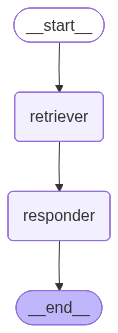

In [8]:
# -----------------------------
# 4. Build LangGraph
# -----------------------------

builder = StateGraph(RAGState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)

builder.set_entry_point("retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [9]:
import os
# from langgraph.prebuilt import create_react_agent
# from langchain.agents import Tool
# from langchain.tools import WikipediaQueryRun

from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader

from langgraph.graph import END
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool


In [10]:
# --------------------------
# 1. Create Retriever Tool
# --------------------------

# Load content from blog
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [11]:
def retriever_tool_func(query: str) -> str:
    print("📚 Using RAGRetriever tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [12]:
retriever_tool_func("what are autonomous agents")

📚 Using RAGRetriever tool


'Or\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate Problem Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).\nBoiko et al. (2023) also looked into LLM-empowered agents for scientific discovery, to handle autonomous design, planning, and performance of complex scientific experiments. This agent can use tools to browse the Internet, read documentation, execute code, call robotics experimentation APIs and leverage other LLMs.\nFor example, when requested to "develop a novel anticancer drug", the model came up with the following reasoning steps:\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered

In [13]:
@tool
def retrieve_tool(query: str)->str:
    """  use this tool to fetch a revelant knowldge base info"""
    docs = retriever.invoke(query) #this is will return a List of Documents 
    return "\n".join([doc.page_content for doc in docs])

In [14]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_core.tools import tool
wiki = WikipediaAPIWrapper()

@tool
def wiki_tool(query: str) -> str:
    """Search Wikipedia for general knowledge information"""
    return wiki.run(query)

In [15]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

C:\Users\palas\AppData\Local\Temp\ipykernel_9372\3279723887.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node = create_react_agent(llm, tools)


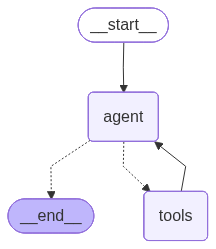

In [16]:
tools = [retrieve_tool, wiki_tool]

react_node = create_react_agent(llm, tools)
react_node

In [ ]:
import os
from typing import List
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END


In [1]:
# prepare vectoe store
docs = TextLoader("C:\Users\palas\Desktop\GenAI\9_autonomous_rag\78-83-Autonomousrag.pdf", encoding="utf-8").load()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3891871852.py, line 2)

In [ ]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
vectorstore  = FAISS.from_docuemt(chunks, embedding)
retriever = vectorstore.as_retriever()

In [ ]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

In [ ]:
# defining the state
class RAGCoTState(BaseModel):
    question : str
    sub_steps : List[str] = []
    retrieve_docs : List[Document] = []
    answer : str = ""


In [ ]:
# -------------------------------
# 3. Nodes
# -------------------------------

# a. Plan sub-questions
def plan_steps(state:RAGCoTState)->RAGCoTState:
    prompt=f"Break the question into 2-3 reasoning steps: \n\n {state.question}"
    result=llm.invoke(prompt).content
    subqs=[line.strip("- ") for line in result.split("\n") if line.strip()]

    return state.model_copy(update={"sub_steps":subqs})


In [ ]:
# retriever for each step
def retrieve_per_step(state:RAGCoTState) ->RAGCoTState:
    

In [ ]:
class RAGReflectionState(BaseModel):
    question : str
    retrieved_docs : List[Document] = []
    answer: str = ""
    reflection : str = ""
    revised : bool = False
    attempts : int = 0
    

In [ ]:
def retrieve_docs(state : RAGReflectionState) -> RAGReflectionState:
    docs = retriever.invoke(state.question)
    return state.model_copy(update={"retrieved_docs":docs})

def generate_answer(state : RAGReflectionState) -> RAGReflectionState:
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
Use the following context to answer the question:

Context:
{context}

Question:
{state.question}
"""
    
    answer = llm.invoke(promt).content.strip()
    return state.model_copy(update={"answer":answer, "attempts" : state.attempts +1})



In [ ]:
def finalize(state : RAGReflectionState) -> RAGReflectionState:
    return state


In [ ]:
builder = StateGraph(RAGReflectionState)
builder.add_node("retriever", retrieve_docs)

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

docs  = []

for url in urls:
    docs.extend(WebBaseLoader(url).load())

splitter = RecursiveCharacterTextSplitter()
embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(splitter.split_documents(docs), embedding)
retriever = vectorstore.as_retriever()

In [ ]:
class RAGState(BaseModel):
    question : str
    sub_queries = List[Document] = []
    answer : str = ""
     

In [ ]:
class ItRAG(BaseModel):
    question : str 
    refined_question : str = ""
    retrieved_docs : List[Document] =[]
    answer : str
    verified : bool = False
    attempts : int = 0

In [ ]:
def ret(state : ItRAG) -> ItRAG:
    querry = ItRAG.refined_question or ItRAG.question
    docs = retriever.invoke(query)
    